In [6]:
import custom_funcs as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sklearn.cross_validation as cv

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from itertools import combinations
from random import sample
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem Set on Machine Learning

## Problem 1

Identify the original literature reference for the PhenoSense assay. Paste the URL to the PubMed article below, and write a one-paragraph summary on how the assay is done.

### Your Answer Here

Double-click on this the answer cells, and start typing your answers. The cells will recognize Markdown. The most important things you may need are **bolded** text and *italicized* text, as well as:

1. Numbered
1. Lists
    1. With
    1. Sub-pointers

Also, you may like

- Bulleted 
- lists
    - with
    - subpointers
- indentations are 4 spaces in.

## Problem 2

1. Identify the protease drugs for which the two drugs' resistance values are correlated. 
1. Write code below to calculate their correlation score. 
1. Search around the academic literature on these drugs, and provide an explanation as to why they would be correlated.

**Answer to Question 1:**

The protease drugs that are most correlated are: **[put your answer here]**

In [7]:
# This cell loads the data and cleans it for you, and log10 transforms the drug resistance values.
DATA_HANDLE = 'drug_data/hiv-protease-data.csv'  # specify the relative path to the protease drug resistance data
N_DATA = 8  # specify the number of columns in the CSV file that are drug resistance measurements.
CONSENSUS = 'sequences/hiv-protease-consensus.fasta'  # specify the relative path to the HIV protease consensus sequence
data, drug_cols, feat_cols = cf.read_data(DATA_HANDLE, N_DATA)
consensus_map = cf.read_consensus(CONSENSUS)
data = cf.clean_data(data, feat_cols, consensus_map)
for name in drug_cols:
    data[name] = data[name].apply(np.log10)
data.head()

,FPV,ATV,IDV,LPV,NFV,SQV,TPV,DRV,P1,P2,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
SeqID,,,,,,,,,,,,,,,,,,,,,
2996,0.397940,NaN,1.212188,NaN,1.586587,1.206826,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
4387,-0.154902,NaN,-0.096910,NaN,-0.096910,0.041393,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4432,0.176091,NaN,0.000000,NaN,0.342423,0.041393,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4482,0.591065,NaN,1.305351,NaN,1.334454,0.963788,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
4486,0.977724,1.30103,0.913814,1.041393,1.857332,1.662758,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F


In [8]:
"""
Complete the function below to compute the correlation score.

Use the scipy.stats.pearsonr(x, y) function to find the correlation score between two arrays of things. 
You do not need to type the whole name, as I have imported the pearsonr name for you, so you only have to do:

    pearsonr(x, y)

Procedure:

1. Select two columns' names to compare.
2. Make sure to drop NaN values. the pearsonr function cannot deal with NaN values. 
   (Refer to the Lecture notebook if you forgot how to do this.)
3. Pass the data in to pearsonr().

"""
def corr_score(drug1, drug2):
    ### BEGIN SOLUTION
    # Get the subset of data
    subset = data[[drug1, drug2]].dropna()
    # Return the pearsonr score.
    return pearsonr(subset[drug1], subset[drug2])
    ### END SOLUTION

In [9]:
assert corr_score('IDV', 'FPV') == (0.79921991532901282, 2.6346448659104859e-306)
assert corr_score('ATV', 'FPV') == (0.82009597442033089, 2.5199367322520278e-231)
assert corr_score('NFV', 'DRV') == (0.69148264851159791, 4.0640711263961111e-82)
assert corr_score('LPV', 'SQV') == (0.76682619729899326, 4.2705737581002648e-234)

**Your answer to question 3:**

[Put your answer here]

## Problem 3

Fill in the code below to plot the relationship between number of estimators (X-axis) and the MSE value for each of the estimators. 

- Try 10, 30, 50, 80, 100, 300, 500 and 800 estimators. 
- Use the ShuffleSplit iterator with cross-validation.
- Use mean of at least 5 cross-validated MSE scores.

In [10]:
# Fill in the code here to clean the data.
def return_cleaned_data(drug_name, data):
    # Select the subsets of columns of interest.
    # Fade out the drug_name and feat_cols variables
    cols_of_interest = []
    cols_of_interest.append(drug_name)
    cols_of_interest.extend(feat_cols)
     
    subset = data[cols_of_interest].dropna()  # fade out .dropna()
    Y = subset[drug_name]  # fade out drug_name, fade out .apply(np.log10)
    X = subset[feat_cols]
    # We call on a custom function to binarize the sequence feature matrix.
    # You can inspect the code in the custom_funcs.py file.
    lb = LabelBinarizer()
    lb.fit(list('CHIMSVAGLPTRFYWDNEQK'))

    X_binarized = pd.DataFrame()

    for col in X.columns:
        binarized_cols = lb.transform(X[col])

        for i, c in enumerate(lb.classes_):
            X_binarized[col + '_' + c] = binarized_cols[:,i]
    
    return X_binarized, Y

X_binarized, Y = return_cleaned_data('FPV', data)
len(X_binarized), len(Y)

(1415, 1415)

In [90]:
num_estimators = [10, 30,]  # fill in the number of estimators to try here.
models = {'Random Forest':RandomForestRegressor,
          'Ada Boost':AdaBoostRegressor,
          'Gradient Boost':GradientBoostingRegressor,
          'Extra Trees':ExtraTreesRegressor}  # fill in the other models here

# Initialize a dictionary to hold the models' MSE values.
mses = dict()
for model_name, model in models.items():
    mses[model_name] = dict()
    for n in num_estimators:
        mses[model_name][n] = 0

# Iterate over the models, and number of estimators.
for model_name, model in models.items():
    for n_est in num_estimators:
        ### Begin Here
        print(model_name, n_est)
        # Set up the cross-validation iterator
        cv_iterator = cv.ShuffleSplit(len(X_binarized), test_size=0.3, n_iter=5)
        
        # Initialize the model
        m = model(n_estimators=n_est) # fill in the parameters
        
        # Collect the cross-validation scores. Remember that mse will be negative, and needs to
        # be transformed to be positive.
        cv_scores = cv.cross_val_score(m, X_binarized, Y, cv=cv_iterator, scoring='mean_squared_error') 
        # Store the mean MSEs.
        mses[model_name][n_est] = np.mean(-cv_scores)
        ### End Here
        
        

Random Forest 10
Random Forest 30
Gradient Boost 10
Gradient Boost 30
Extra Trees 10
Extra Trees 30
Ada Boost 10
Ada Boost 30


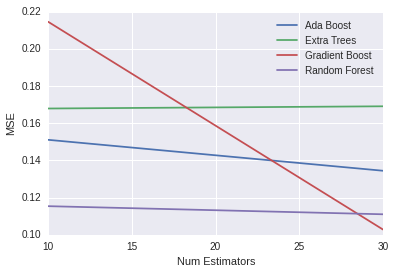

In [91]:
# When you're done, run the following cell to make your plot.
pd.DataFrame(mses).plot()
plt.xlabel('Num Estimators')
plt.ylabel('MSE')

**Question:** How many estimators would be optimal? What is the biggest driver of this decision?

## Problem 4

- Pick the best model from above, and re-train it on the dataset again. Refer to the Lecture notebook for a version of the code that may help here!
- Now, use it to make predictions on the global HIV protease dataset.
- Plot the global distribution.

In [83]:
# Load in the data and binarize it.
proteases = [s for s in SeqIO.parse('sequences/HIV1-protease.fasta', 'fasta') if len(s) == 99]
alignment = MultipleSeqAlignment(proteases)
proteases_df = pd.DataFrame(np.array([list(rec) for rec in alignment], str))
proteases_df.index = [s.id for s in proteases]
proteases_df.columns = [i for i in range(1, 100)]
X_global = cf.binarize_seqfeature(proteases_df)

(array([  2.06000000e+02,   3.00620000e+04,   9.95490000e+04,
          1.26980000e+04,   5.37700000e+03,   3.80000000e+03,
          2.69500000e+03,   1.37600000e+03,   3.76000000e+02,
          8.40000000e+01]),
 array([-1.        , -0.639794  , -0.279588  ,  0.080618  ,  0.440824  ,
         0.80103   ,  1.16123599,  1.52144199,  1.88164799,  2.24185399,
         2.60205999]),
 <a list of 10 Patch objects>)

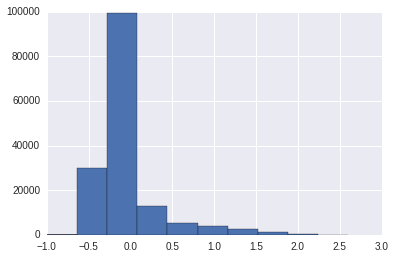

In [89]:
# Train your model here, with optimized parameters for best MSE minimization.
### BEGIN
model = RandomForestRegressor()  # put your best model here.
model.fit(X_binarized, Y)
preds = model.predict(X_global)
plt.hist(preds)
### END

**Question:**

How would you evaluate whether the predictions are correct?